##### In this notebook, we will use the trained Global model to forecast traffic density for all (selected) GEOHASH for the month of April 2023 and then compare the forecasts with actual test traffic density.

In [1]:
import time
import pickle
import warnings
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

import pandas as pd
import polars as pl
pl.enable_string_cache(True)

warnings.filterwarnings('ignore')

from sklearn.metrics import mean_squared_error
from tqdm.auto import tqdm

plt.rcParams['font.weight'] = 'bold'
seed=42

In [2]:
# loading trained baseline model
with open("final_model.pkl", "rb") as r:
    trained_model = pickle.load(r)

trained_model

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('datetimefeatures',
                                  DatetimeFeatures(features_to_extract=['year',
                                                                        'month',
                                                                        'day_of_month',
                                                                        'hour',
                                                                        'day_of_week'],
                                                   variables='index')),
                                 ('ordinalencoder',
                                  OrdinalEncoder(encoding_method='arbitrary',
                                                 variables=['GEOHASH',
                                                            'DISTRICT',
                                                            'LOCATION_TYPE',
                                                            'HOLIDAY_NAME',
                                                            'HOLIDAY_TYPE',
                                                            'SCHOOL_HOLIDAY_TYPE',
                                                            'WTHR_CAT'])),
                                 ('cyclicalfeatures',
                                  CyclicalFeatures(drop_original=True,
                                                   variables=['month',
                                                              'day_of_month',
                                                              'hour',
                                                              'day_of_week']))])),
                ('lgbmregressor',
                 LGBMRegressor(colsample_bytree=0.676, learning_rate=0.0223,
                               max_depth=6, min_child_weight=0.0017,
                               n_estimators=266, num_leaves=87, random_state=42,
                               reg_alpha=2.3, reg_lambda=0.011))])

# Preparing test set

In [3]:
top_TD_GH_by_district = np.array(
    pl.scan_parquet("../datasets/19_model/train.zstd")
    .groupby(['DISTRICT', 'GEOHASH'])
    .agg(pl.col(['NUMBER_OF_VEHICLES']).mean())
    .sort(['DISTRICT', 'NUMBER_OF_VEHICLES'], descending=True)
    .with_columns(pl.col('NUMBER_OF_VEHICLES').rank('dense', descending=True).over('DISTRICT').alias('TD_row'))
    .filter(pl.col('TD_row').le(20))
    .select('GEOHASH')
    .collect(streaming=True)
    .to_series()
    .to_list()
    # .to_pandas()
    # .to_excel("datasets/18_Viz/top_10_td_gh_district.xlsx", index=False)
)

len(top_TD_GH_by_district)

720

In [4]:
# Preparing test set
X_test = (
    pl.read_parquet("../datasets/19_model/test.zstd")
    .filter(pl.col('GEOHASH').is_in(top_TD_GH_by_district))
    .drop('NUMBER_OF_VEHICLES')
    .sort(['DATE_TIME', 'GEOHASH'])
    .to_pandas()

    # Replacing all TD_LAG1, TD_LAG24 and TD_LAG168 with null values except for the first hour
    .assign(TD_LAG1=lambda x: np.where(x['DATE_TIME'].eq("2023-04-01 00:00:00"), x['TD_LAG1'], np.nan),
            TD_LAG24=lambda x: np.where(x['DATE_TIME'].eq("2023-04-01 00:00:00"), x['TD_LAG24'], np.nan),
            TD_LAG168=lambda x: np.where(x['DATE_TIME'].eq("2023-04-01 00:00:00"), x['TD_LAG168'], np.nan))

    .set_index('DATE_TIME')
)

X_test.head()

GEOHASH      DISTRICT LOCATION_TYPE  CITIZEN_RETURN  \
DATE_TIME                                                        
2023-04-01  sxk90n  Bahçelievler        avenue          628203   
2023-04-01  sxk3pn  Küçükçekmece        avenue          628203   
2023-04-01  sxkcd0      Çekmeköy        street          628203   
2023-04-01  sxk97t       Beyoğlu         other          628203   
2023-04-01  sxk3w7    Başakşehir        street          628203   

            CITIZEN_ARRIVAL  TOURIST_ARRIVAL        HOLIDAY_NAME  \
DATE_TIME                                                          
2023-04-01           641667          1289903  Ramadan Observance   
2023-04-01           641667          1289903  Ramadan Observance   
2023-04-01           641667          1289903  Ramadan Observance   
2023-04-01           641667          1289903  Ramadan Observance   
2023-04-01           641667          1289903  Ramadan Observance   

                  HOLIDAY_TYPE SCHOOL_HOLIDAY_TYPE  HIGHWAY_TRNSPRT_PSNGRS  \
DATE_TIME                                                                    
2023-04-01  Ramadan Observance         Non Holiday                   14754   
2023-04-01  Ramadan Observance         Non Holiday                   14754   
2023-04-01  Ramadan Observance         Non Holiday                   14754   
2023-04-01  Ramadan Observance         Non Holiday                   14754   
2023-04-01  Ramadan Observance         Non Holiday                   14754   

            ...  HUMIDITY  PRCP  WINDSPEED  WTHR_CAT  TD_LAG1  TD_LAG24  \
DATE_TIME   ...                                                           
2023-04-01  ...        73   0.0  30.400000    normal    305.0     176.0   
2023-04-01  ...        73   0.0  30.400000    normal    259.0     155.0   
2023-04-01  ...        68   0.0  30.500000    normal    137.0     124.0   
2023-04-01  ...        71   0.0  30.799999    normal     71.0      37.0   
2023-04-01  ...        73   0.0  30.400000    normal    168.0     129.0   

            TD_LAG168  PRCP_LAG1  PRCP_LAG2  PRCP_LAG3  
DATE_TIME                                               
2023-04-01      138.0        0.0        0.0        0.0  
2023-04-01      115.0        0.0        0.0        0.0  
2023-04-01       86.0        0.0        0.1        0.0  
2023-04-01       27.0        0.0        0.0        0.0  
2023-04-01       78.0        0.0        0.0        0.0  

[5 rows x 35 columns]

In [5]:
all_actual_forecasts = (
    pl.concat([
        (
            pl.read_parquet("../datasets/19_model/train.zstd")
            .filter(pl.col('GEOHASH').is_in(top_TD_GH_by_district))
            .with_columns(pl.col(['GEOHASH', 'DISTRICT']).cast(pl.Utf8).cast(pl.Categorical))
            .select(['DATE_TIME', 'GEOHASH', 'DISTRICT', 'NUMBER_OF_VEHICLES'], pl.col(['NUMBER_OF_VEHICLES']).alias('FORECAST'))
            .sort(['DATE_TIME', 'GEOHASH'])
        ),
        (
            pl.read_parquet("../datasets/19_model/valid.zstd")
            .filter(pl.col('GEOHASH').is_in(top_TD_GH_by_district))
            .with_columns(pl.col(['GEOHASH', 'DISTRICT']).cast(pl.Utf8).cast(pl.Categorical))
            .select(['DATE_TIME', 'GEOHASH', 'DISTRICT', 'NUMBER_OF_VEHICLES'], pl.col(['NUMBER_OF_VEHICLES']).alias('FORECAST'))
            .sort(['DATE_TIME', 'GEOHASH'])
        ),
        (
            pl.read_parquet("../datasets/19_model/test.zstd")
            .filter(pl.col('GEOHASH').is_in(top_TD_GH_by_district))
            .with_columns(pl.col(['GEOHASH', 'DISTRICT']).cast(pl.Utf8).cast(pl.Categorical))
            .select(['DATE_TIME', 'GEOHASH', 'DISTRICT', 'NUMBER_OF_VEHICLES'],
                    pl.lit(None).alias('FORECAST').cast(pl.UInt16))
            .sort(['DATE_TIME', 'GEOHASH'])
        )
        ])
    .to_pandas()
    .set_index('DATE_TIME')
)

all_actual_forecasts.head()

GEOHASH      DISTRICT  NUMBER_OF_VEHICLES  FORECAST
DATE_TIME                                                     
2020-01-01  sxk90n  Bahçelievler                 192     192.0
2020-01-01  sxk3pn  Küçükçekmece                 185     185.0
2020-01-01  sxkcd0      Çekmeköy                  32      32.0
2020-01-01  sxk97t       Beyoğlu                  40      40.0
2020-01-01  sxk3w7    Başakşehir                 122     122.0

## Forecasting

In [6]:
forecast_horizon = pd.date_range("2023-04-01 00:00:00", "2023-04-30 23:00:00", freq='H')

In [7]:
for date in tqdm(forecast_horizon):

    if date==pd.to_datetime("2023-04-01 00:00:00"):
        
        X = X_test.loc[date]
        forecast = trained_model.predict(X)
        all_actual_forecasts.loc[date, 'FORECAST'] = forecast

    else:
        # assign previous hour forecast TD to current hour TD_LAG1
        X_test.loc[date, "TD_LAG1"] = all_actual_forecasts.loc[date-pd.offsets.Hour(1), "FORECAST"].values

        # assign previous 24 hour forecast TD to current TD_LAG24
        X_test.loc[date, "TD_LAG24"] = all_actual_forecasts.loc[date-pd.offsets.Hour(24), "FORECAST"].values

        # assign previous 168 hour forecast TD to current TD_LAG168
        X_test.loc[date, "TD_LAG168"] = all_actual_forecasts.loc[date-pd.offsets.Hour(168), "FORECAST"].values

        X = X_test.loc[date]
        forecast = trained_model.predict(X)
        all_actual_forecasts.loc[date, 'FORECAST'] = forecast

  0%|          | 0/720 [00:00<?, ?it/s]

In [8]:
test_actual_forecasts = all_actual_forecasts.loc["2023-04-01 00:00:00":]
test_actual_forecasts

GEOHASH       DISTRICT  NUMBER_OF_VEHICLES    FORECAST
DATE_TIME                                                                 
2023-04-01 00:00:00  sxk90n   Bahçelievler                 262  178.463159
2023-04-01 00:00:00  sxk3pn   Küçükçekmece                 208  157.379990
2023-04-01 00:00:00  sxkcd0       Çekmeköy                 123  110.300772
2023-04-01 00:00:00  sxk97t        Beyoğlu                  51   44.046815
2023-04-01 00:00:00  sxk3w7     Başakşehir                 151  116.581055
...                     ...            ...                 ...         ...
2023-04-30 23:00:00  sxk3nt   Küçükçekmece                 273  246.463522
2023-04-30 23:00:00  sxkc62     Sancaktepe                 126  116.688793
2023-04-30 23:00:00  sxk9e3          Şişli                  57   63.857057
2023-04-30 23:00:00  sxk99u  Gaziosmanpaşa                  94   85.978408
2023-04-30 23:00:00  sxk9d7  Gaziosmanpaşa                  35   31.227432

[518400 rows x 4 columns]

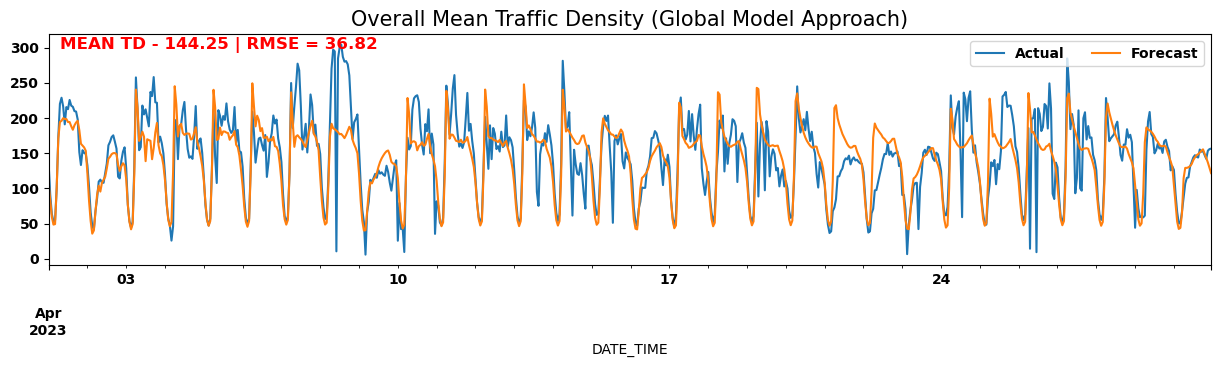

In [9]:
rmse = mean_squared_error(
    y_true=test_actual_forecasts.resample('H')['NUMBER_OF_VEHICLES'].mean(),
    y_pred=test_actual_forecasts.resample('H')['FORECAST'].mean(),
    squared=False
)

mean_td = (
    test_actual_forecasts
    .resample('H')['NUMBER_OF_VEHICLES'].mean()
    .mean()
)

ax = (
    test_actual_forecasts
    .resample('H')[['NUMBER_OF_VEHICLES', 'FORECAST']].mean()
    .plot(figsize=(15, 3))
)

ax.set_title("Overall Mean Traffic Density (Global Model Approach)", fontsize=15)

ax.text(0.01, 0.99, f'MEAN TD - {mean_td:.2f} | RMSE = {rmse:.2f}', ha='left', va='top', 
        transform=ax.transAxes, fontsize=12, fontweight='bold', color='r')

ax.legend(labels=["Actual", "Forecast"], ncol=2, loc="upper right");

In [10]:
(
    test_actual_forecasts
    .groupby('GEOHASH')
    .apply(lambda x: mean_squared_error(y_true=x['NUMBER_OF_VEHICLES'], y_pred=x['FORECAST'], squared=False))
    .sort_values()
)

GEOHASH
sxk9db      9.284662
sxk96y      9.666694
sxk96z     10.530308
sxk97s     12.109197
sxk91y     12.168565
             ...    
sxk3rs    125.243615
sxk9pq    127.318163
sxk985    130.033234
sxk3xd    141.567389
sxk3xe    149.946716
Length: 720, dtype: float64

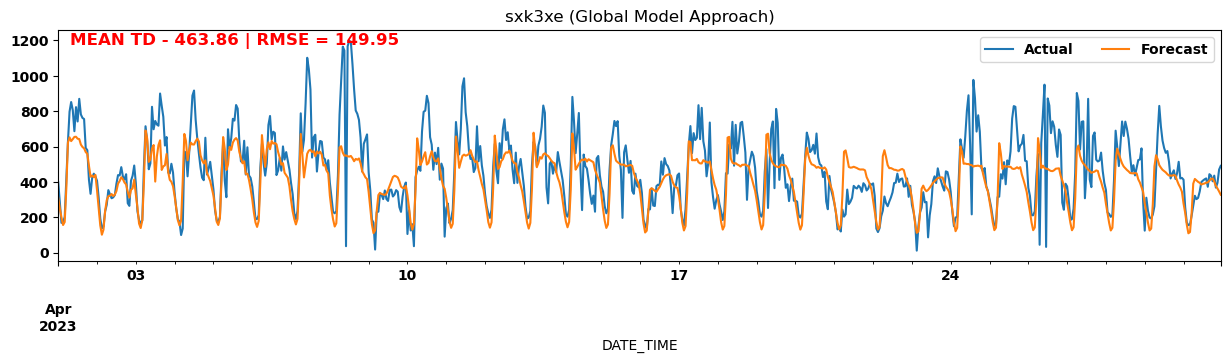

In [11]:
ax = (
    test_actual_forecasts.query("GEOHASH=='sxk3xe'")
    .plot(y=['NUMBER_OF_VEHICLES', 'FORECAST'], figsize=(15, 3))
)

rmse = mean_squared_error(
    y_true=test_actual_forecasts.query("GEOHASH=='sxk3xe'")['NUMBER_OF_VEHICLES'],
    y_pred=test_actual_forecasts.query("GEOHASH=='sxk3xe'")['FORECAST'],
    squared=False
)

mean_td = test_actual_forecasts.query("GEOHASH=='sxk3xe'")['NUMBER_OF_VEHICLES'].mean()

ax.text(0.01, 0.99, f'MEAN TD - {mean_td:.2f} | RMSE = {rmse:.2f}', ha='left', va='top', 
        transform=ax.transAxes, fontsize=12, fontweight='bold', color='r')

ax.set_title('sxk3xe (Global Model Approach)')
ax.legend(labels=["Actual", "Forecast"], ncol=2, loc="upper right");

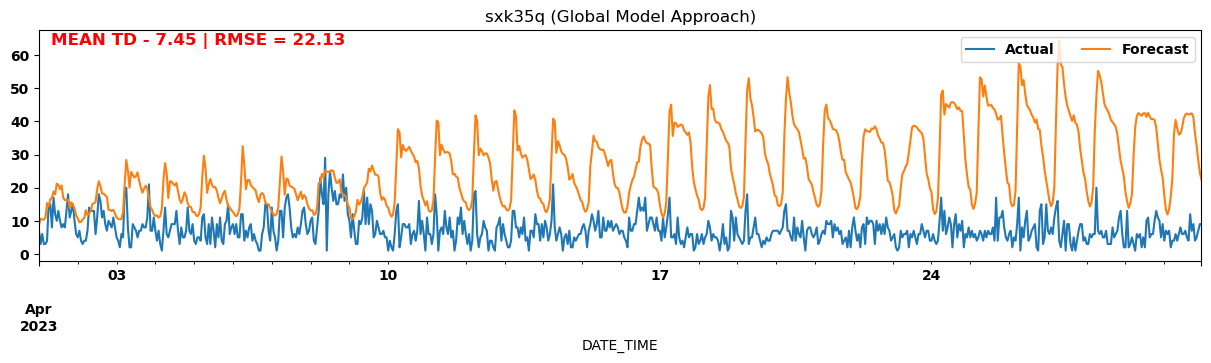

In [12]:
ax = (
    test_actual_forecasts.query("GEOHASH=='sxk35q'")
    .plot(y=['NUMBER_OF_VEHICLES', 'FORECAST'], figsize=(15, 3))
)

rmse = mean_squared_error(
    y_true=test_actual_forecasts.query("GEOHASH=='sxk35q'")['NUMBER_OF_VEHICLES'],
    y_pred=test_actual_forecasts.query("GEOHASH=='sxk35q'")['FORECAST'],
    squared=False
)

mean_td = test_actual_forecasts.query("GEOHASH=='sxk35q'")['NUMBER_OF_VEHICLES'].mean()

ax.text(0.01, 0.99, f'MEAN TD - {mean_td:.2f} | RMSE = {rmse:.2f}', ha='left', va='top', 
        transform=ax.transAxes, fontsize=12, fontweight='bold', color='r')

ax.set_title('sxk35q (Global Model Approach)')
ax.legend(labels=["Actual", "Forecast"], ncol=2, loc="upper right");

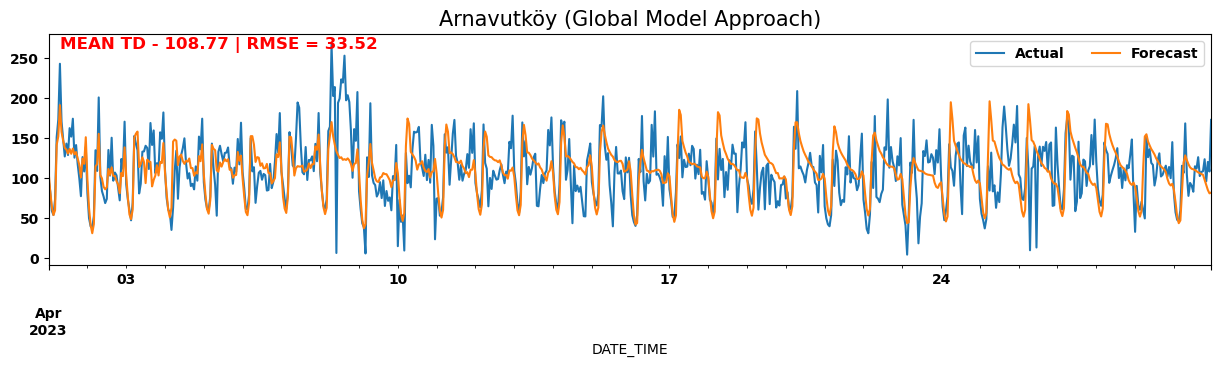

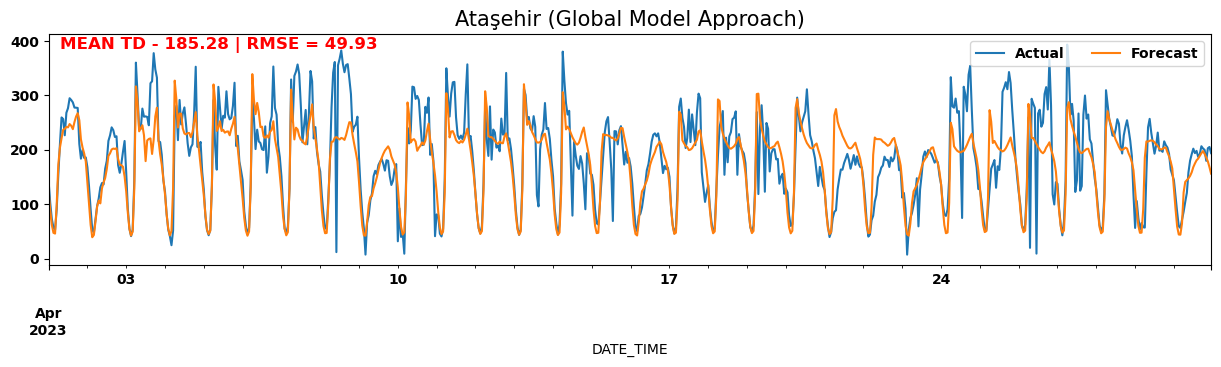

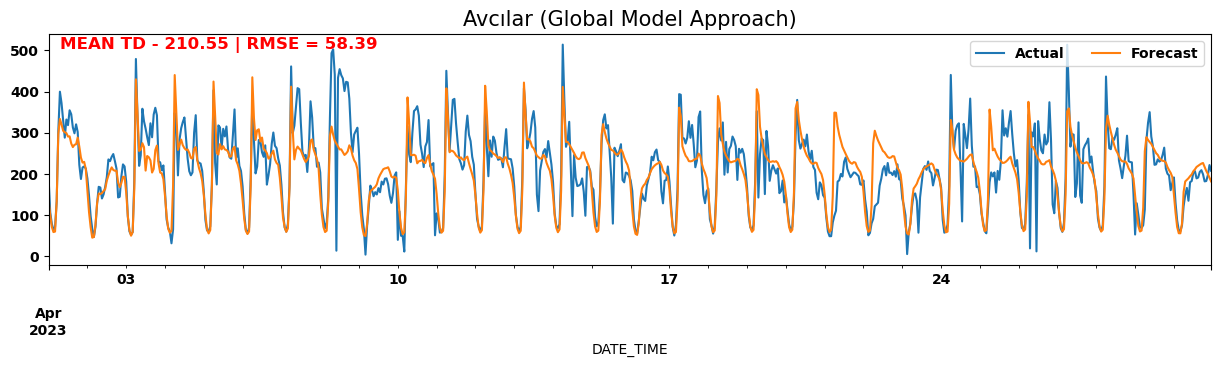

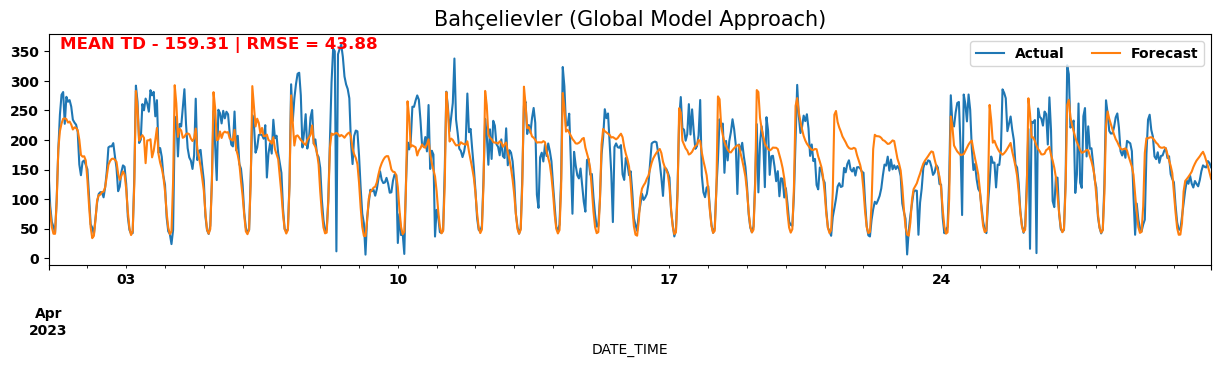

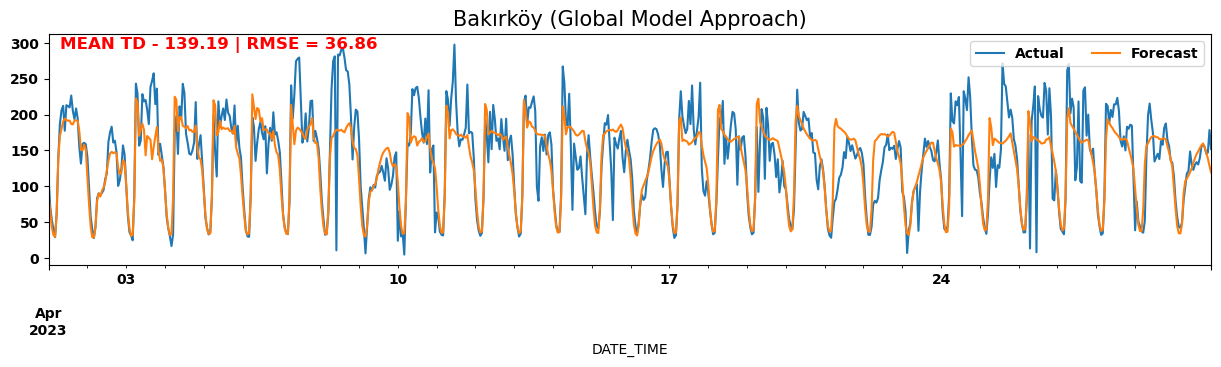

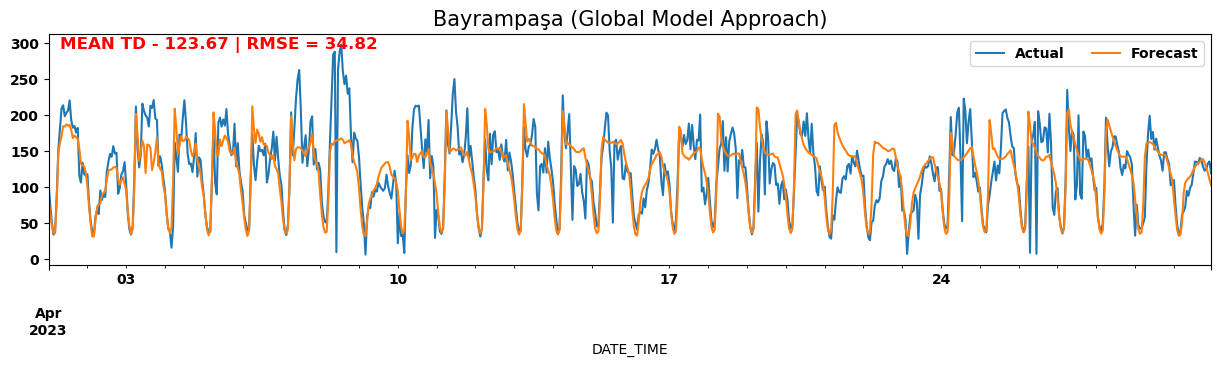

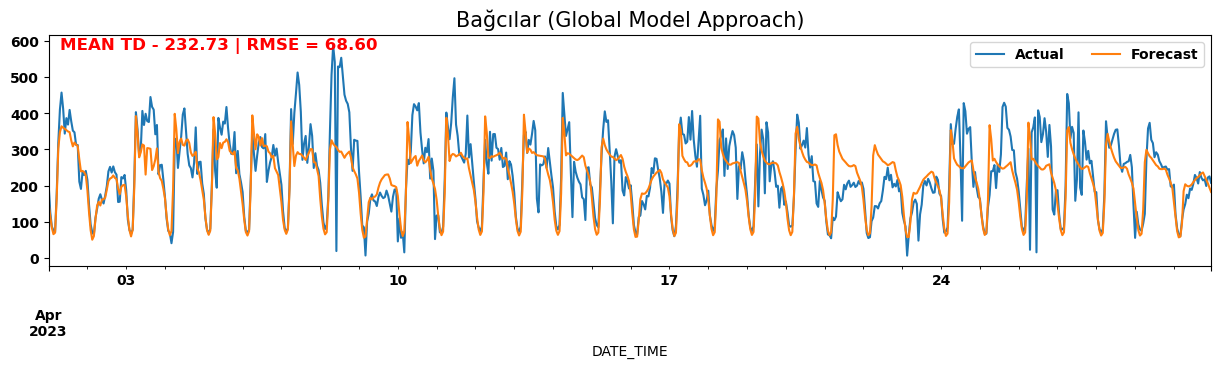

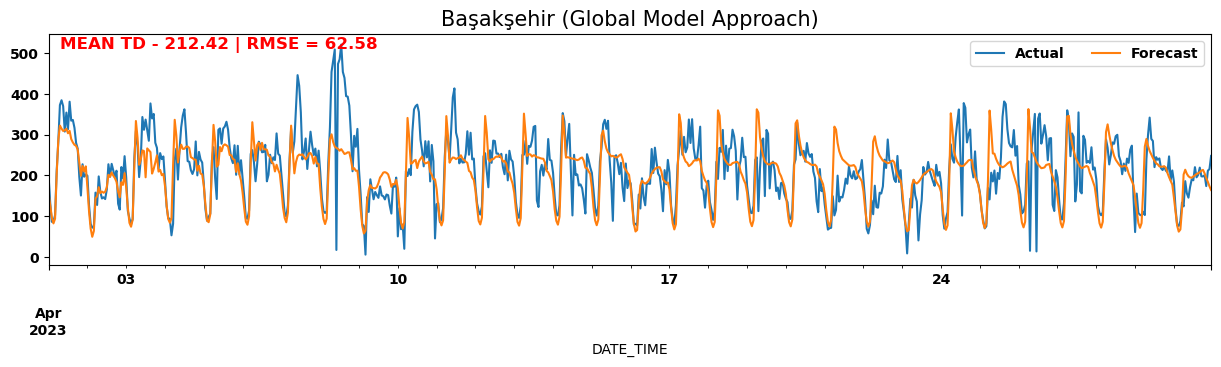

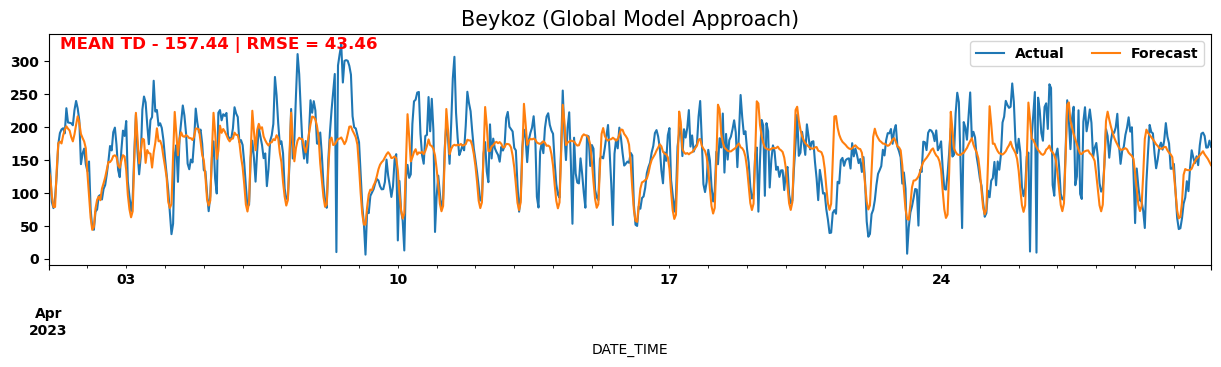

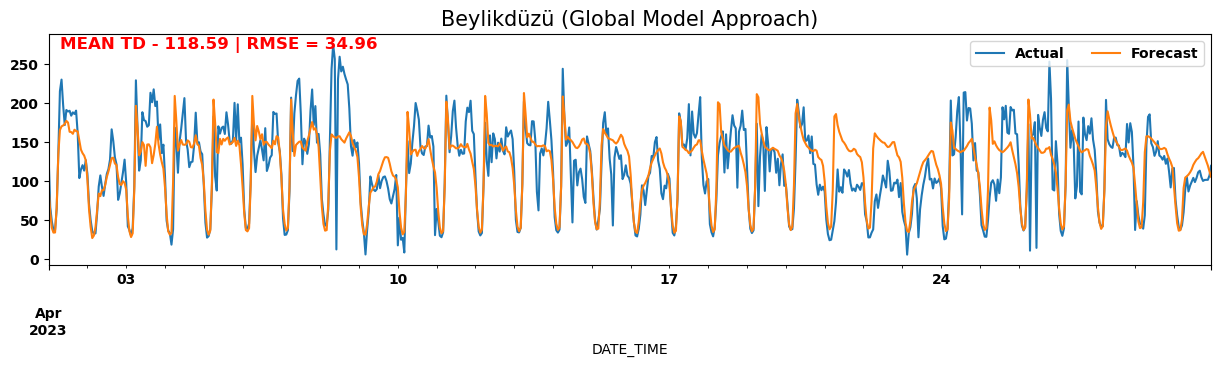

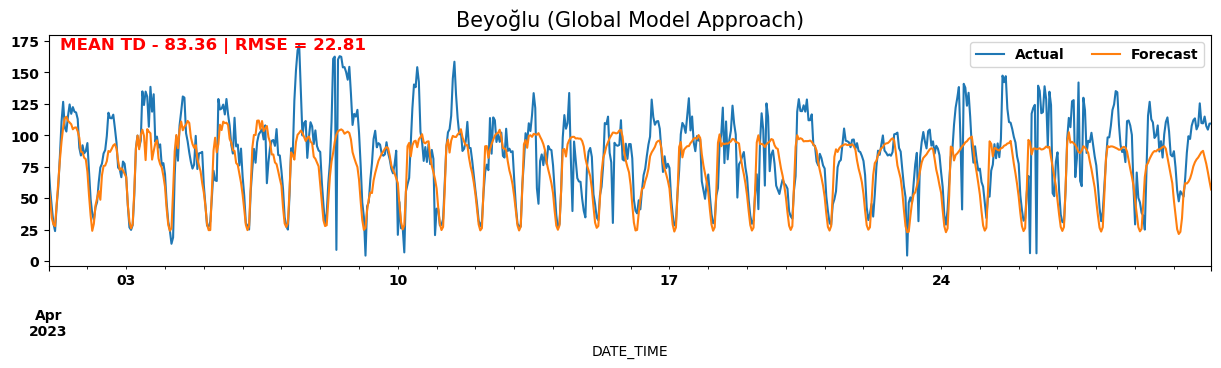

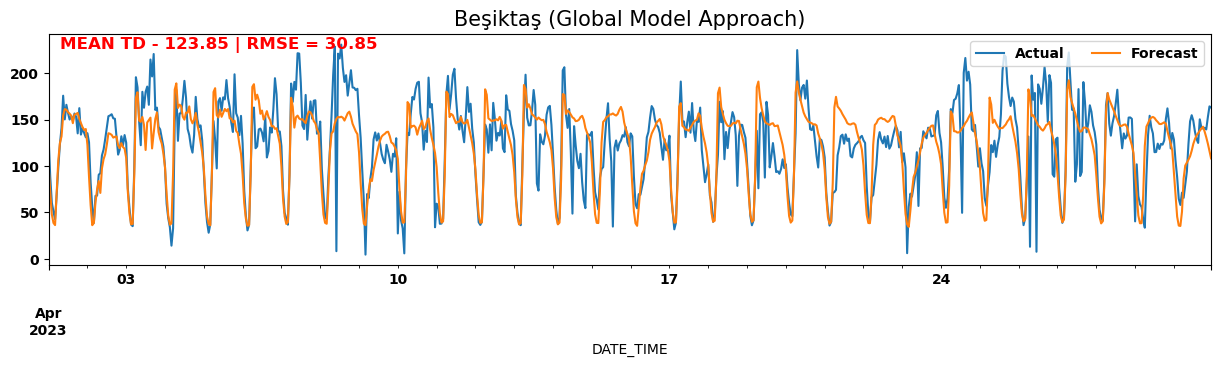

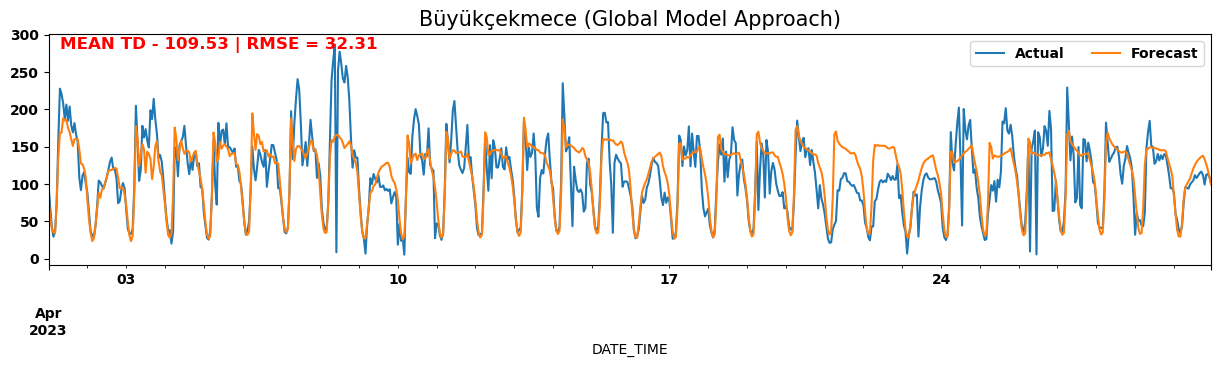

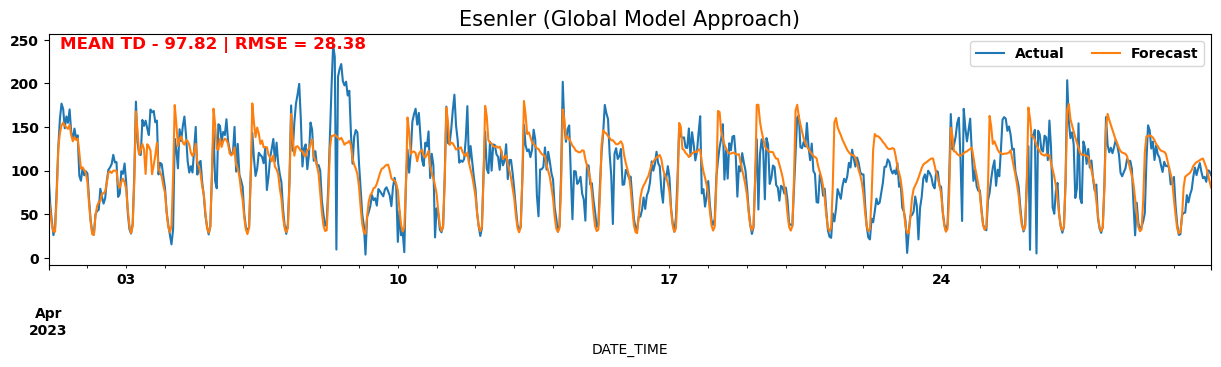

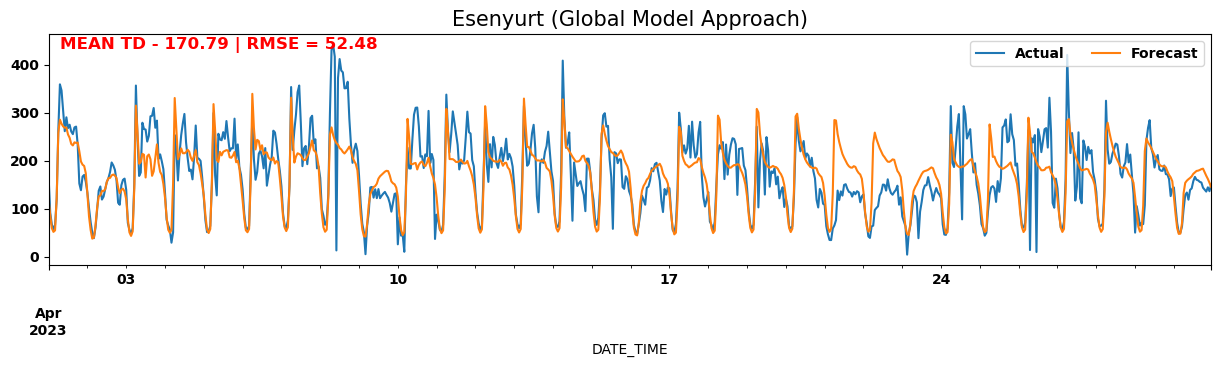

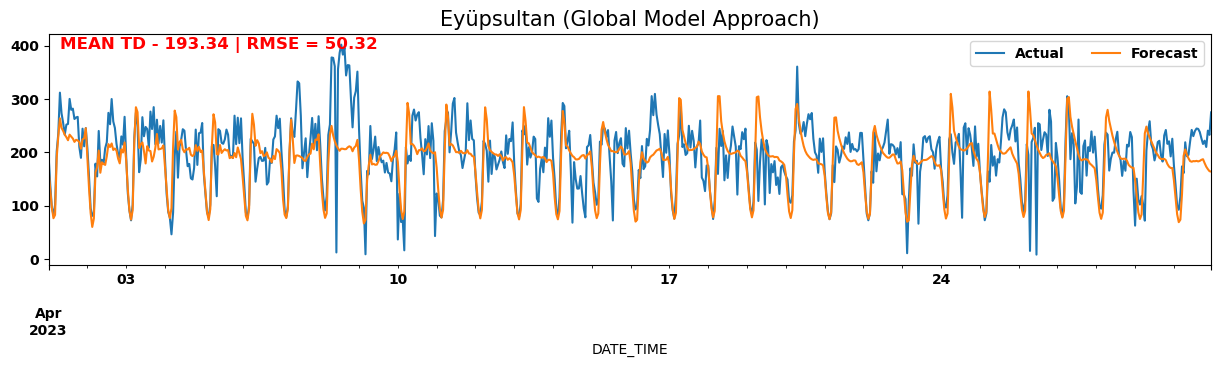

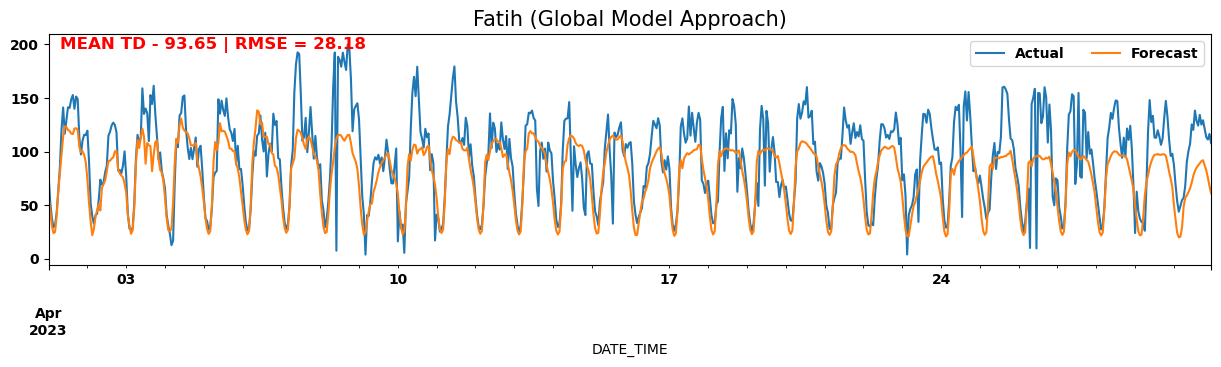

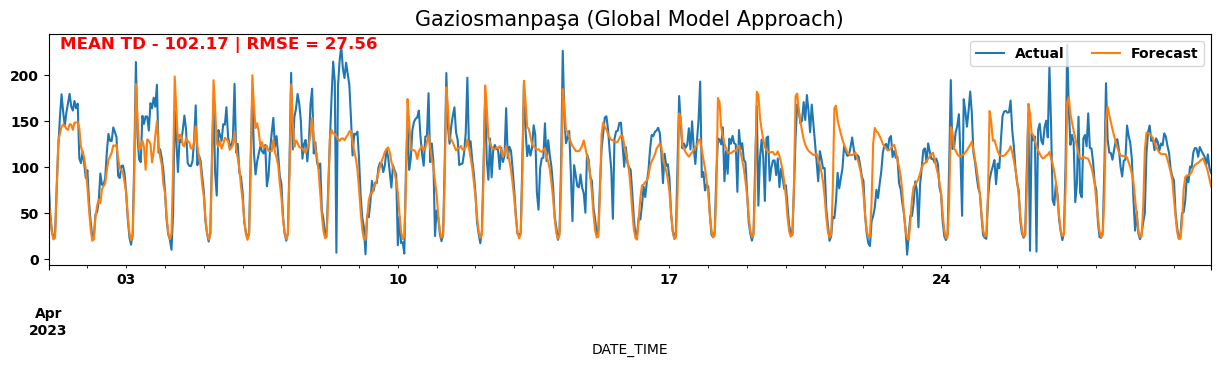

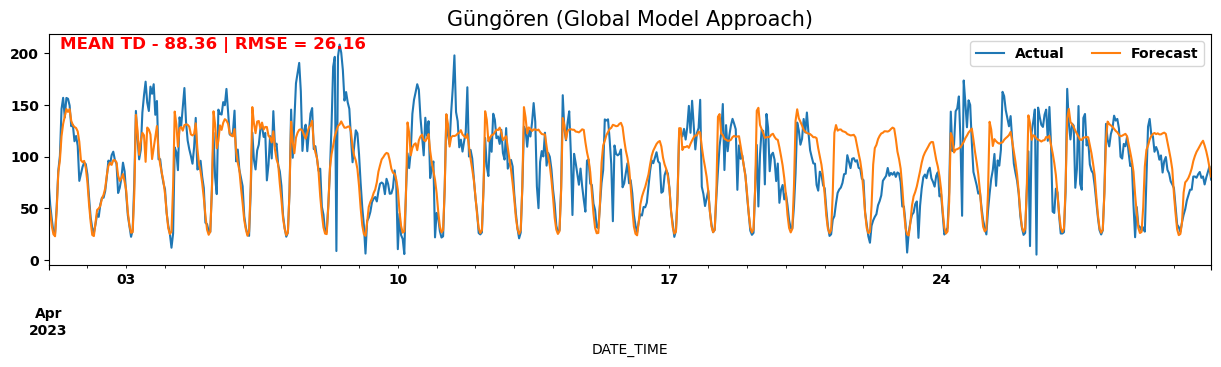

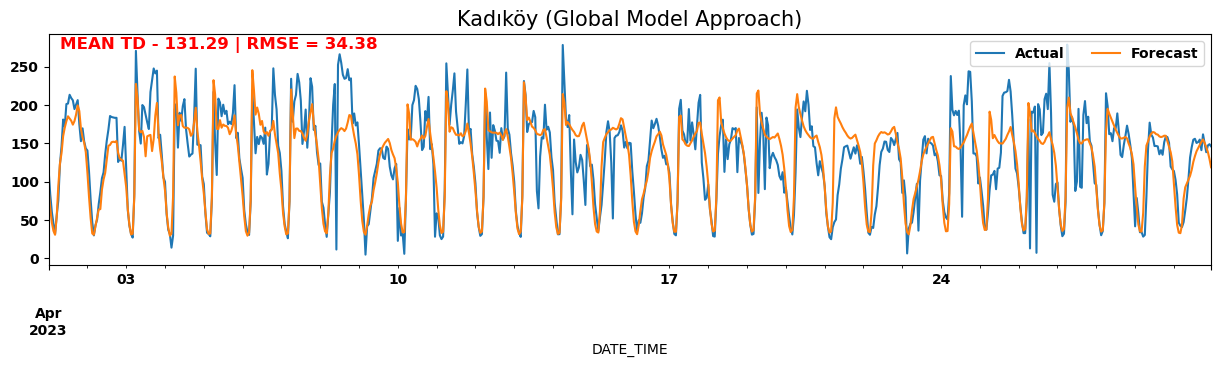

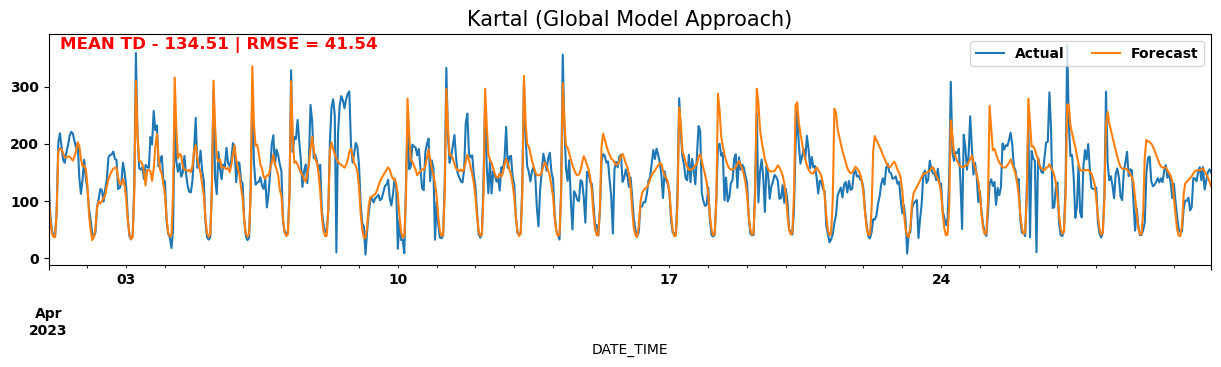

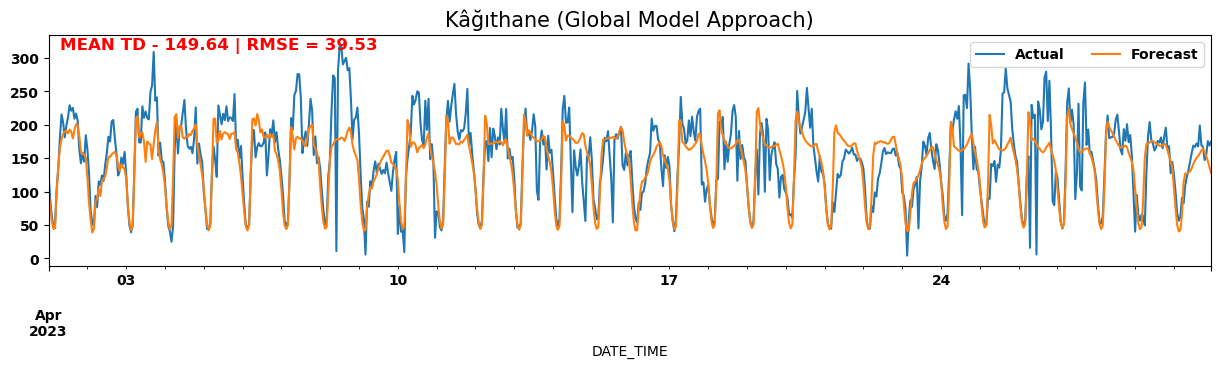

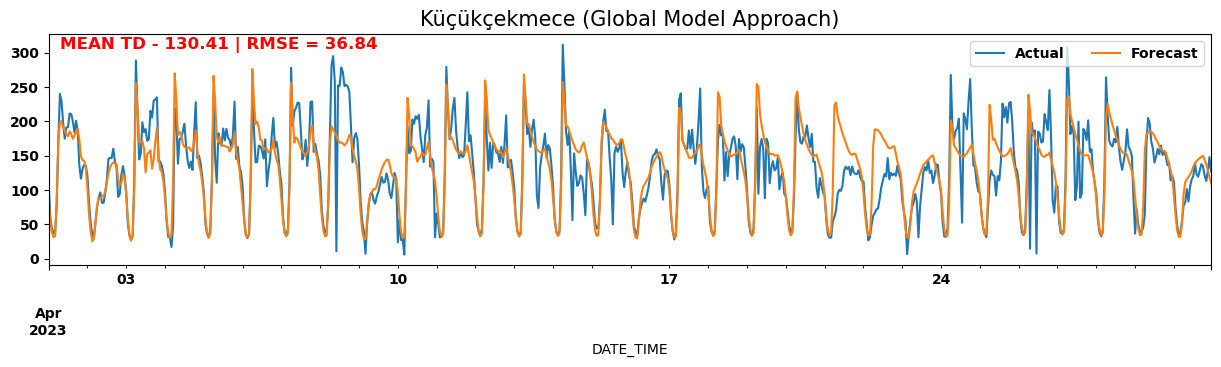

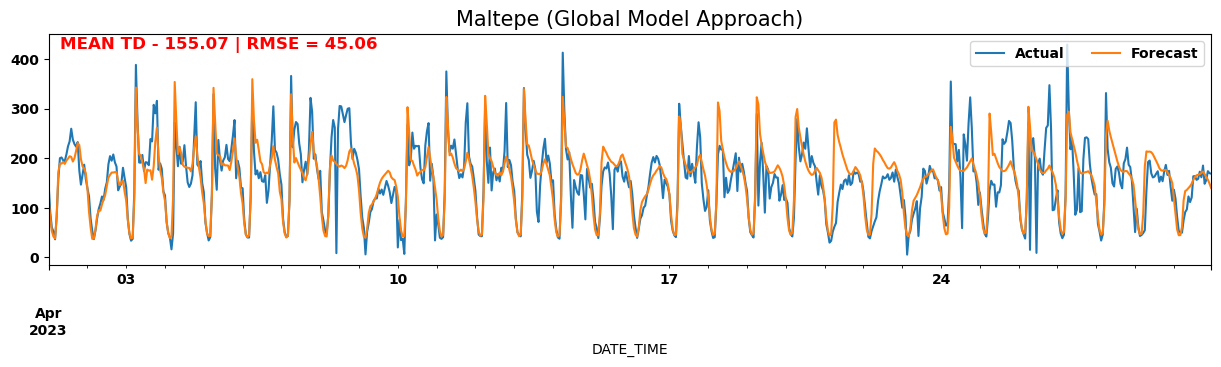

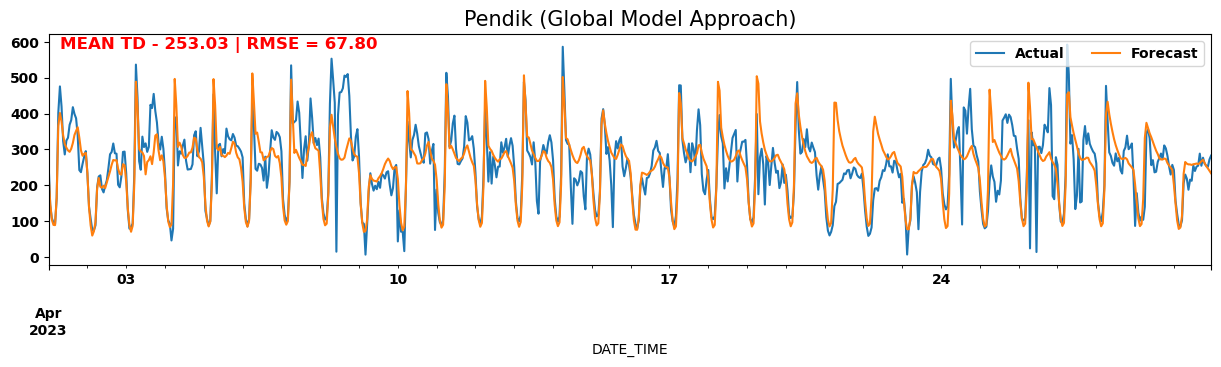

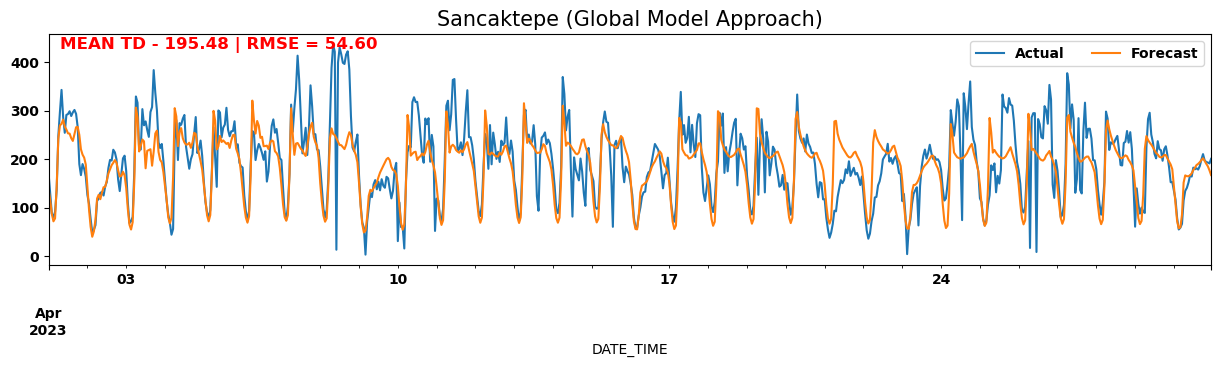

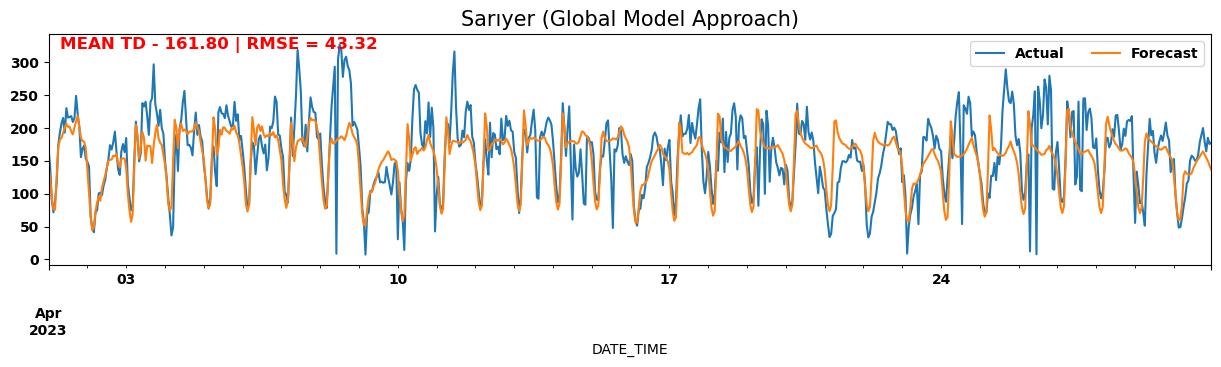

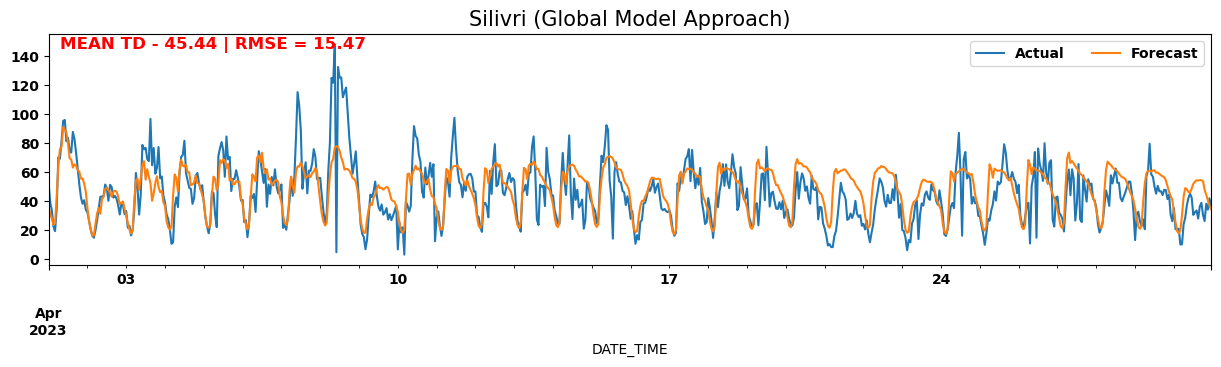

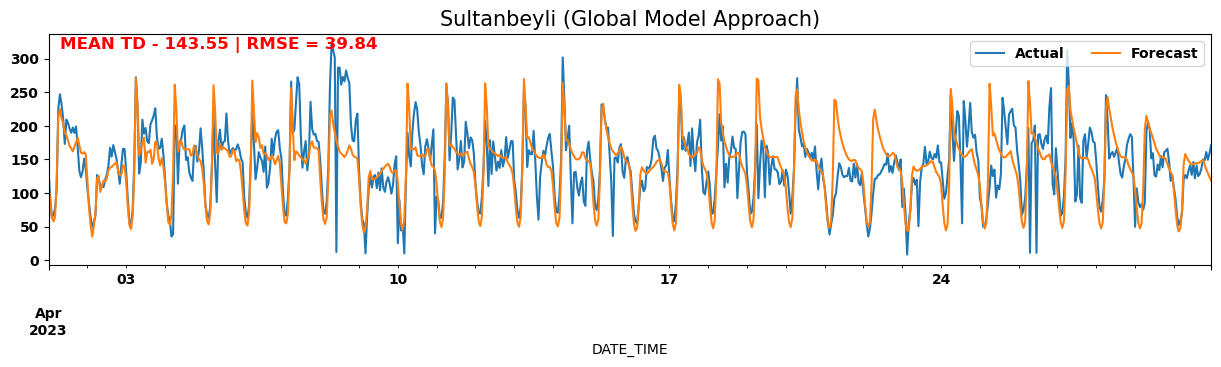

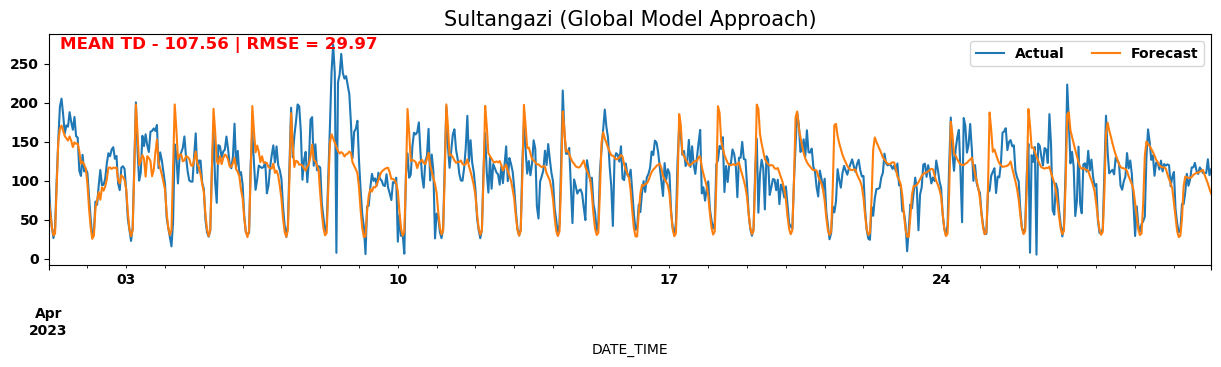

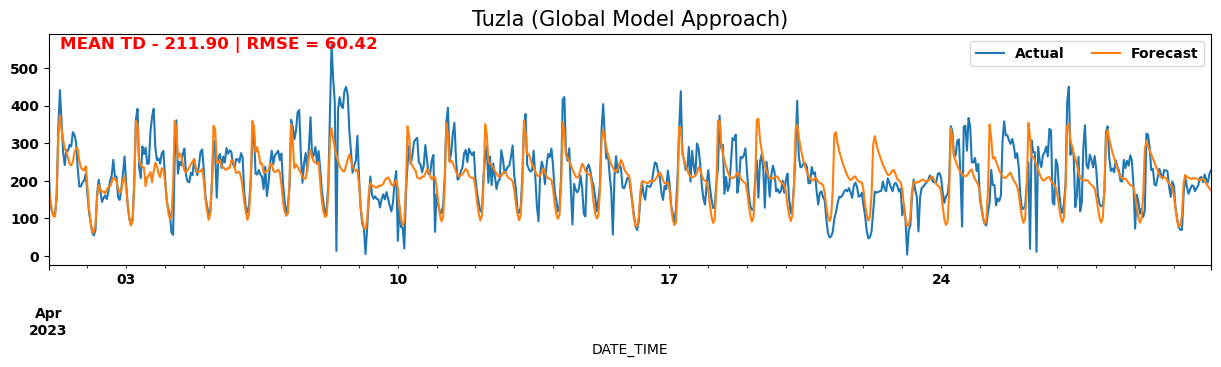

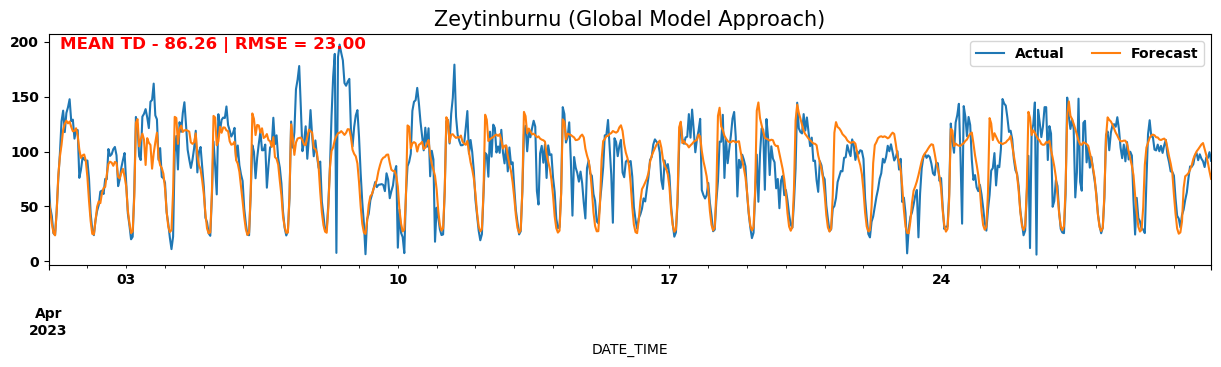

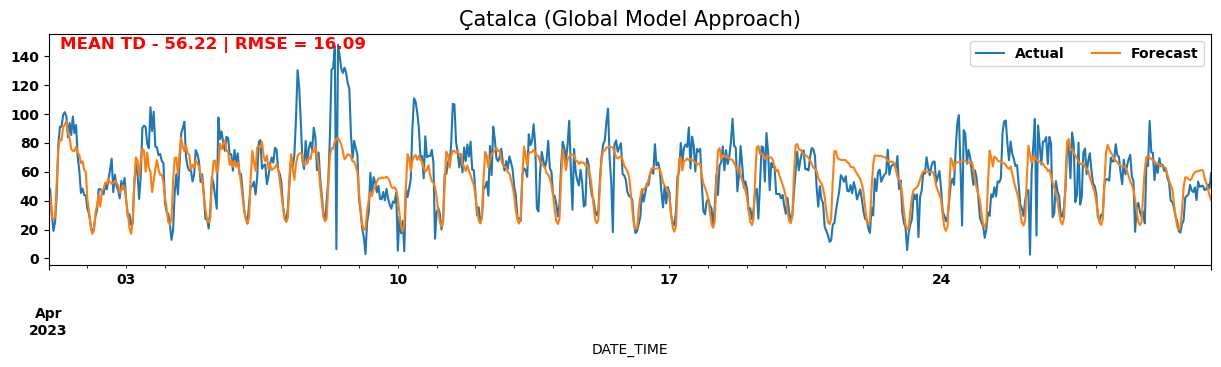

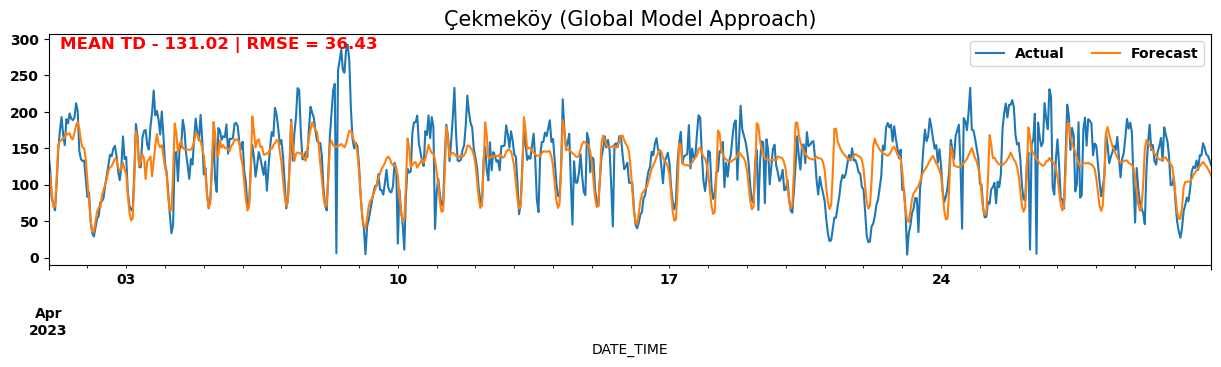

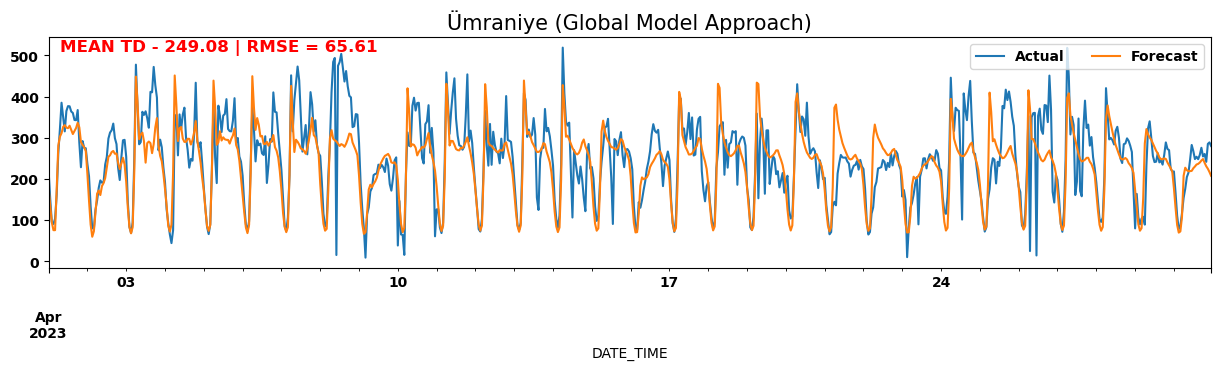

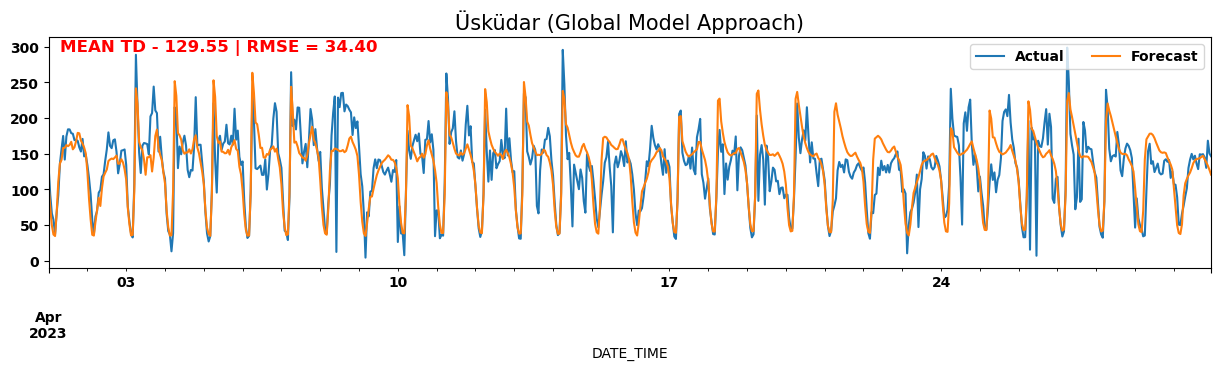

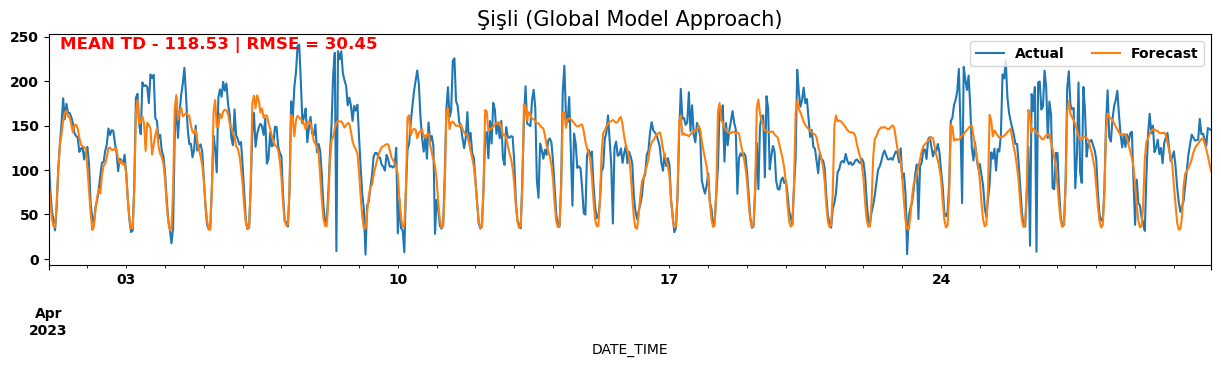

In [13]:
for district in np.sort(test_actual_forecasts['DISTRICT'].unique()):

    temp_df = (
        test_actual_forecasts
        .query(f"DISTRICT=='{district}'")
        .resample('H')[['NUMBER_OF_VEHICLES', 'FORECAST']].mean()
    )
    
    
    rmse = mean_squared_error(
        y_true=temp_df['NUMBER_OF_VEHICLES'],
        y_pred=temp_df['FORECAST'],
        squared=False
    )
    
    mean_td = temp_df['NUMBER_OF_VEHICLES'].mean()
    
    ax = (
        temp_df
        .plot(y=['NUMBER_OF_VEHICLES', 'FORECAST'], figsize=(15, 3))
    )

    ax.set_title(f"{district} (Global Model Approach)", fontsize=15)

    ax.text(0.01, 0.99, f'MEAN TD - {mean_td:.2f} | RMSE = {rmse:.2f}', ha='left', va='top', 
        transform=ax.transAxes, fontsize=12, fontweight='bold', color='r')
    
    ax.legend(labels=["Actual", "Forecast"], ncol=2, loc="upper right")
    
    plt.show();